In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Peugeot.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_106,Seri_107,Seri_205,...,Model_GTI,Model_Quicksilver,Model_XR,Model_XS,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,475000,2015,93,1560,119000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,848000,2018,122,1560,52000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,255000,2006,71,1398,178000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,187000,1998,90,1587,210000,11.0,2.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,315000,2002,110,1587,198000,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_1244\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45467.58975,2.160463e+09,46480.781274,30537.536197


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:20:29,564] A new study created in memory with name: no-name-edd2b65c-a5cb-41b3-b515-5fdda2f349a0
[I 2023-10-08 14:20:29,871] Trial 0 finished with value: 398453.0145346454 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.0017177839571828949, 'max_depth': 14, 'min_child_weight': 92}. Best is trial 0 with value: 398453.0145346454.
[I 2023-10-08 14:20:29,916] Trial 4 finished with value: 117918.78942768055 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.20191880296963052, 'max_depth': 5, 'min_child_weight': 255}. Best is trial 4 with value: 117918.78942768055.
[I 2023-10-08 14:20:29,916] Trial 6 finished with value: 403503.3372207443 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.00030710510481168836, 'max_depth': 3, 'min_child_weight': 265}. Best is trial 4 with value: 117918.78942768055.
[I 2023-10-08 14:20:29,965] Trial 2 finished with value: 398062.62074638024 and parameters: 

[I 2023-10-08 14:20:31,679] Trial 29 finished with value: 238965.1045439245 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.057203468942088366, 'max_depth': 10, 'min_child_weight': 46}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:31,755] Trial 32 finished with value: 184671.5466614181 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.0845446888081741, 'max_depth': 9, 'min_child_weight': 41}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:31,755] Trial 31 finished with value: 188059.56955328374 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.08262281369047848, 'max_depth': 9, 'min_child_weight': 45}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:31,822] Trial 33 finished with value: 186684.27970104874 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.08341730766721261, 'max_depth': 9, 'min_child_weight'

[I 2023-10-08 14:20:33,777] Trial 60 finished with value: 81033.93480653889 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.40453825820744554, 'max_depth': 10, 'min_child_weight': 85}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:33,821] Trial 61 finished with value: 68389.4536794501 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.39498314117362987, 'max_depth': 3, 'min_child_weight': 58}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:33,885] Trial 62 finished with value: 66603.0783345761 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.39025040683653817, 'max_depth': 15, 'min_child_weight': 55}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:33,927] Trial 64 finished with value: 66786.6666247099 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.41498306393121637, 'max_depth': 10, 'min_child_weight': 6

[I 2023-10-08 14:20:36,060] Trial 91 finished with value: 51392.22490483453 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.3276338858198723, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:36,091] Trial 90 finished with value: 61051.405924990504 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.22540899549768934, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:36,140] Trial 92 finished with value: 65313.679898534814 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.21374166613134346, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 19 with value: 44771.86201954491.
[I 2023-10-08 14:20:36,206] Trial 93 finished with value: 62230.752021196626 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.2230477843339736, 'max_depth': 13, 'min_child_weight': 1}

[I 2023-10-08 14:20:38,446] Trial 120 finished with value: 46474.23338849101 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4737303647690739, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:38,496] Trial 121 finished with value: 49487.83868964607 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4932726364682617, 'max_depth': 12, 'min_child_weight': 19}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:38,529] Trial 122 finished with value: 54746.36702646776 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.4160661962052336, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:38,564] Trial 124 finished with value: 54152.178825930205 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.39187448696955224, 'max_depth': 7, 'min_child_w

[I 2023-10-08 14:20:40,775] Trial 150 finished with value: 48393.03675348094 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4186414018113347, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:41,017] Trial 151 finished with value: 48845.18210382392 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.42438114913809405, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:41,017] Trial 152 finished with value: 46771.36773684868 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4939425360093063, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:41,032] Trial 153 finished with value: 46159.13793003332 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4999068466701633, 'max_depth': 12, 'min_child_we

[I 2023-10-08 14:20:43,461] Trial 180 finished with value: 49627.33573525381 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4249211122670439, 'max_depth': 12, 'min_child_weight': 10}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:43,503] Trial 181 finished with value: 47980.299242586174 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4143724563346875, 'max_depth': 12, 'min_child_weight': 10}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:43,583] Trial 182 finished with value: 50676.04444761448 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.49979075656491995, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:43,611] Trial 183 finished with value: 48521.82155508094 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.498784637333758, 'max_depth': 12, 'min_child_

[I 2023-10-08 14:20:46,202] Trial 210 finished with value: 50065.64279571101 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4884376239007666, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:46,244] Trial 211 finished with value: 89969.72114701207 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1605477776531457, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:46,354] Trial 212 finished with value: 92564.70536323135 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.16178346325398238, 'max_depth': 13, 'min_child_weight': 21}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:46,406] Trial 213 finished with value: 48565.232359730704 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.49824832802746927, 'max_depth': 13, 'min_child_

[I 2023-10-08 14:20:48,959] Trial 239 finished with value: 47067.86471151466 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4053752207375334, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:48,981] Trial 241 finished with value: 46022.407634794305 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.40937989759763627, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:49,029] Trial 243 finished with value: 46956.86943419764 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4048896763488722, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 108 with value: 44498.160282566714.
[I 2023-10-08 14:20:49,050] Trial 242 finished with value: 47997.62749980875 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4132459494969533, 'max_depth': 12, 'min_child_w

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 44498.1603
Best params:
	colsample_bytree: 0.8
	subsample: 1.0
	learning_rate: 0.4924534236012971
	max_depth: 7
	min_child_weight: 7


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 50212.64137260319, 'MSE': 2244443234.386688, 'RMSE': 47375.55524093294, 'MAE': 32820.157753661086}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9246726538545572

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9122670336938283

In [16]:
marka_model = joblib.dump(final_model, "Peugeot.pkl")

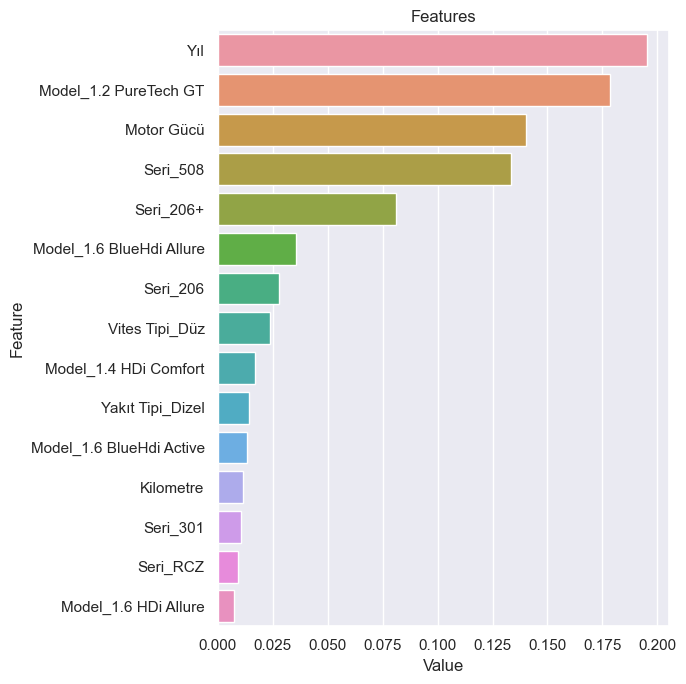

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)